In [155]:
import plotly.graph_objects as go
import pandas as pd

df = pd.read_csv('../output/results.csv', engine='pyarrow')
df = df[df['tech'] != 'm1'] # This is merging files on the laptop
df['function'] = df['function'].str.replace('_',' ')
df['function'] = df['function'].str.replace(' merged upload','')
print(f"Errors: {set(df['error'].fillna('').values)}")
print(f"steps count: {df['step'].max()+1}")
df.head()

Errors: {''}
steps count: 100


,time,function,tech,merged,filename,step,file_mb,row_count,sent_mb,recv_mb,sent_mb_1s,recv_mb_1s,error,data_dir,file_count,datetime,pyxet_version,id
4,2.649432,xethub git,xethub,True,file.csv,0,76.200081,68200,0.037109,0.035156,0.044922,0.071289,None,blog,1,11/08/2023 14:58:57,0.1.1,-8262657030240530286
5,26.281029,dvc,dvc,True,file.csv,0,76.200081,68200,1.083008,0.739258,0.066406,0.033203,None,blog,1,11/08/2023 14:58:57,0.1.1,-8262657030240530286
6,4.393438,lfs s3,lfs,True,file.csv,0,76.200081,68200,0.346680,0.232422,0.085938,0.043945,None,blog,1,11/08/2023 14:58:57,0.1.1,-8262657030240530286
7,10.954656,s3,s3,True,file.csv,0,76.200081,68200,80.182617,2.119141,0.045898,0.105469,None,blog,1,11/08/2023 14:58:57,0.1.1,-8262657030240530286
8,3.726403,lfs git,lfs,True,file.csv,0,76.200081,68200,0.041016,0.075195,0.000977,0.000977,None,blog,1,11/08/2023 14:58:57,0.1.1,-8262657030240530286


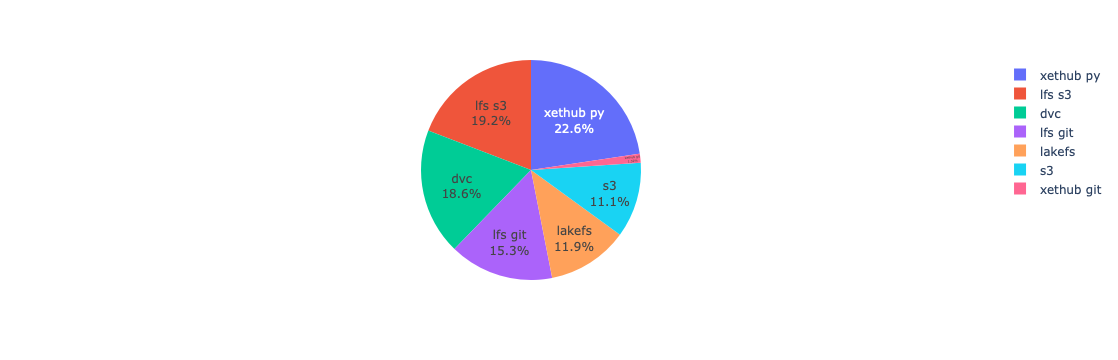

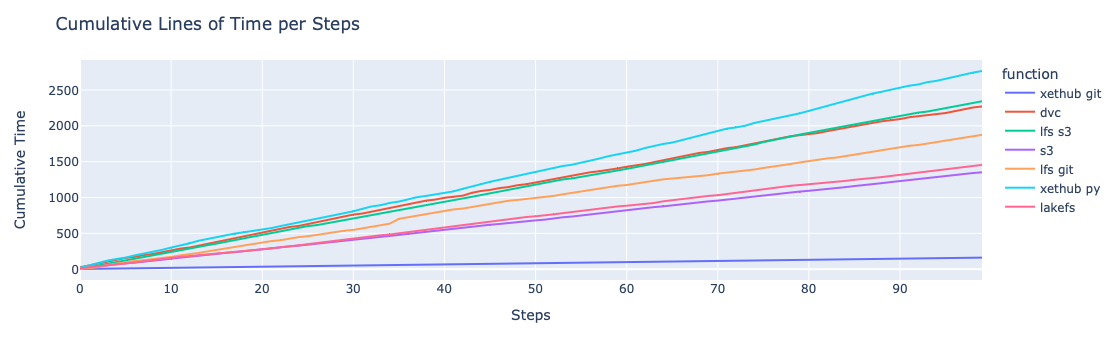

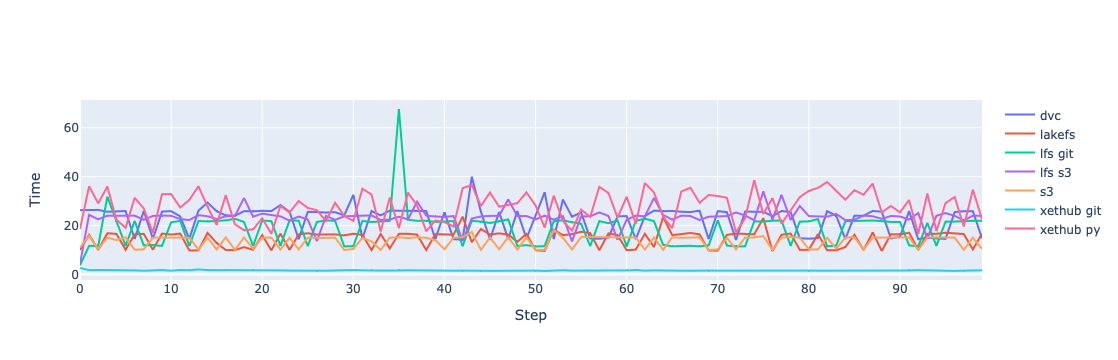

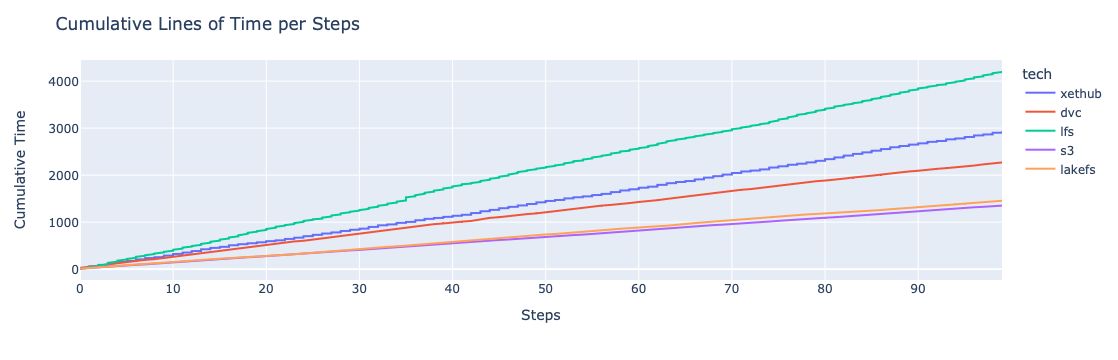

In [156]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

groups = df.groupby('function')
sums = groups.sum()
fig1 = px.pie(sums, values='time', names=sums.index)
fig1.update_traces(textposition='inside', textinfo='percent+label')

fig2 = go.Figure()
for name, group in groups:
    fig2.add_trace(go.Scatter(x=group['step'], y=group['time'], mode='lines', name=str(name)))
fig2.update_layout(xaxis_title='Step', yaxis_title='Time')

df['cumulative_time'] = df.groupby('function')['time'].cumsum()
fig3 = px.line(df, x='step', y='cumulative_time', color='function')
fig3.update_layout(title='Cumulative Lines of Time per Steps', xaxis_title='Steps', yaxis_title='Cumulative Time')

df['tech_cumulative_time'] = df.groupby('tech')['time'].cumsum()

fig4 = px.line(df, x='step', y='tech_cumulative_time', color='tech')
fig4.update_layout(title='Cumulative Lines of Time per Steps',
                  xaxis_title='Steps',
                  yaxis_title='Cumulative Time')

fig1.show()
fig3.show()
fig2.show()
fig4.show()

In [157]:
for step in set(df['step']):
    print(f"Step {step} took {df[df['step']==step]['time'].sum()/60:.2f} minutes")
print(f"total time is: {df['time'].sum()/(60*60):.2f} hours")

Step 0 took 1.28 minutes
Step 1 took 2.21 minutes
Step 2 took 1.86 minutes
Step 3 took 2.52 minutes
Step 4 took 2.11 minutes
Step 5 took 1.80 minutes
Step 6 took 2.00 minutes
Step 7 took 1.93 minutes
Step 8 took 1.57 minutes
Step 9 took 2.13 minutes
Step 10 took 2.28 minutes
Step 11 took 2.15 minutes
Step 12 took 1.76 minutes
Step 13 took 2.17 minutes
Step 14 took 2.27 minutes
Step 15 took 1.92 minutes
Step 16 took 2.16 minutes
Step 17 took 1.88 minutes
Step 18 took 2.08 minutes
Step 19 took 1.70 minutes
Step 20 took 2.15 minutes
Step 21 took 1.92 minutes
Step 22 took 2.01 minutes
Step 23 took 2.03 minutes
Step 24 took 1.97 minutes
Step 25 took 2.01 minutes
Step 26 took 1.99 minutes
Step 27 took 2.10 minutes
Step 28 took 2.20 minutes
Step 29 took 1.85 minutes
Step 30 took 1.98 minutes
Step 31 took 2.14 minutes
Step 32 took 2.16 minutes
Step 33 took 1.90 minutes
Step 34 took 2.15 minutes
Step 35 took 2.83 minutes
Step 36 took 2.29 minutes
Step 37 took 2.31 minutes
Step 38 took 1.93 minu

Average time:


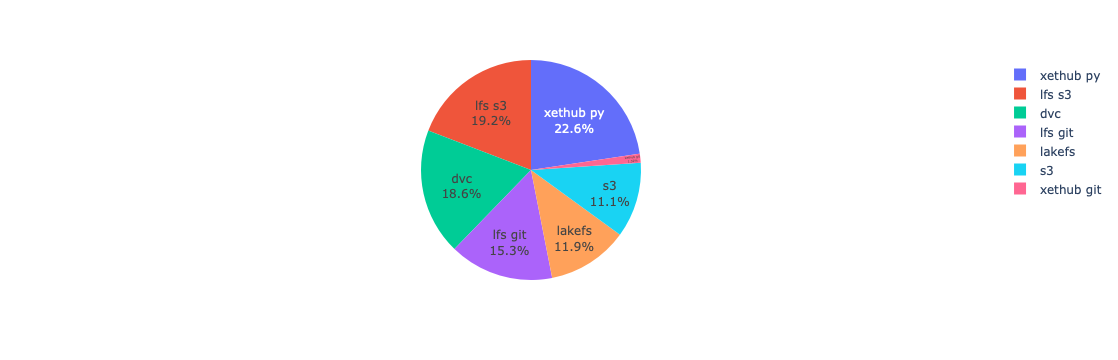

function
xethub git     1.000000
s3             8.373447
lakefs         9.013672
lfs git       11.611614
dvc           14.065719
lfs s3        14.511340
xethub py     17.128700
Name: time, dtype: float64

In [158]:
times = df.groupby('function')['time'].mean()
ratios = times / times.min()
print(f"Average time:")
fig5 = px.pie(times, values='time', names=times.index)
fig5.update_traces(textposition='inside', textinfo='percent+label')
fig5.show()
ratios.sort_values()

Cumulative time ratio:


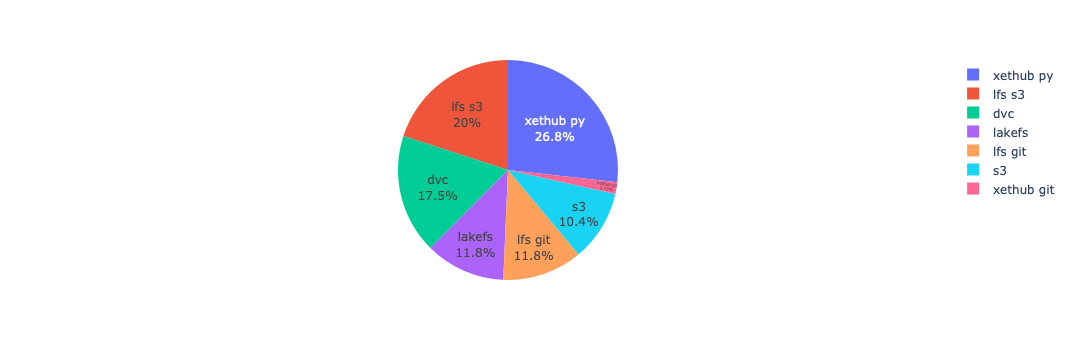

function
xethub git     1.000000
s3             6.081808
lfs git        6.853422
lakefs         6.862887
dvc           10.229989
lfs s3        11.658524
xethub py     15.609970
Name: cumulative_time, dtype: float64

In [150]:
cums_times = df.groupby('function')['cumulative_time'].max()
ratios = cums_times / cums_times.min()
print(f"Cumulative time ratio:")
fig6 = px.pie(cums_times, values='cumulative_time', names=cums_times.index)
fig6.update_traces(textposition='inside', textinfo='percent+label')
fig6.show()
ratios.sort_values()